In [1]:
import numpy as np
import torch

# Contextual Bandits

In [10]:
def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm

In [2]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
    
    def init_distribution(self, arms):
        self.bandit_matrix = np.random.randn(arms, arms)

    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if np.random.random() < prob:
                reward += 1
        return reward

    def get_state(self):
        return self.state

    def update_state(self):
        self.state = np.random.randint(0, self.arms)

    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[[self.get_state()], arm])

    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [3]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state, reward)

2 0


In [4]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [5]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU()
)

In [6]:
loss_fn = torch.nn.MSELoss()

In [7]:
env = ContextBandit(arms)

In [8]:
def one_hot(N, pos, val=1):
    vec = np.zeros(N)
    vec[pos] = val
    return vec

In [9]:
def running_mean(x, N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv) / N
    return y

In [11]:
def train(env, epochs=5000, lr=1e-2):
    cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    rewards = []
    for i in range(epochs):
        y_pred = model(cur_state)
        av_softmax = softmax(y_pred.data.numpy(), tau=0.2)
        av_softmax /= av_softmax.sum()
        choice = np.random.choice(arms, p=av_softmax)
        cur_reward = env.choose_arm(choice)
        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms, env.get_state()))
    return np.array(rewards)

In [12]:
rewards = train(env)

In [14]:
import matplotlib.pyplot as plt

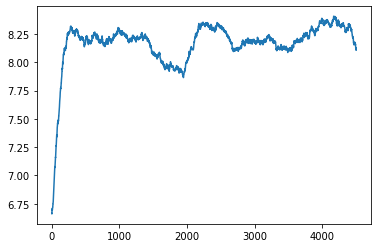

In [15]:
plt.plot(running_mean(rewards, N=500))